In [33]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


from sklearn.model_selection import train_test_split

import pyspark
from pyspark.sql import SparkSession

import pandas as pd
import numpy as np

spark = SparkSession.builder.getOrCreate()

In [34]:
df = spark.read.csv("mimic.csv", header=True, mode="DROPMALFORMED", sep=",")

In [45]:
s = df.sample(False, 0.1, seed=0).limit(100)

In [50]:
pandas_df = s.toPandas()
pandas_df.to_json("mimic_sample.json")

MapPartitionsRDD[36] at toJavaRDD at NativeMethodAccessorImpl.java:0

In [37]:
results = json.loads(result.toJSON().first())

# To decode the entire DataFrame iterate over the result
# of toJSON()

def print_rows(row):
    data = json.loads(row)
    for key in data:
        print "{key}:{value}".format(key=key, value=data[key])


results = result.toJSON()
results.foreach(print_rows)    

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(results[key])? (<ipython-input-37-39e81b2c4bcf>, line 4)

In [32]:
df = spark.read.csv("db_edited2.csv", header=True, mode="DROPMALFORMED", sep=",")

df.printSchema()

pd = df.toPandas()

# data = pd.read.csv("db_edited2.csv")
data = pd.fillna(0)
X = data.iloc[:,0:59]  #independent columns
y = data.iloc[:,-1]    #target column i.e price range


root
 |-- subject_id: string (nullable = true)
 |-- hadm_id: string (nullable = true)
 |-- icustay_id: string (nullable = true)
 |-- age: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- death_label: string (nullable = true)
 |-- BICARBONATE_min: string (nullable = true)
 |-- BICARBONATE_max: string (nullable = true)
 |-- BILIRUBIN_min: string (nullable = true)
 |-- BILIRUBIN_max: string (nullable = true)
 |-- CREATININE_min: string (nullable = true)
 |-- CREATININE_max: string (nullable = true)
 |-- HEMATOCRIT_min: string (nullable = true)
 |-- HEMATOCRIT_max: string (nullable = true)
 |-- HEMOGLOBIN_min: string (nullable = true)
 |-- HEMOGLOBIN_max: string (nullable = true)
 |-- LACTATE_min: string (nullable = true)
 |-- LACTATE_max: string (nullable = true)
 |-- PLATELET_min: string (nullable = true)
 |-- PLATELET_max: string (nullable = true)
 |-- POTASSIUM_min: string (nullable = true)
 |-- POTASSIUM_max: string (nullable = true)
 |-- PT_min: string (nullable = tru

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123456)

In [ ]:
y_train

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
# model.fit(X_train,y_train)
# print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
# #plot graph of feature importances for better visualization
# feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
# feat_importances.nlargest(10).plot(kind='barh')
# plt.show()

# predicted = model.predict(X_test)
# accuracy = accuracy_score(y_test, predicted)

# print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
# print(f'Mean accuracy score: {accuracy:.3}')

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

from sklearn.metrics import accuracy_score

predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

# print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
# print(f'Mean accuracy score: {accuracy:.3}')

In [ ]:
import matplotlib.pyplot as plt, mpld3

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

In [ ]:
plt.plot(fpr, tpr, 'o-', label="Logistic Regression")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('위양성률(Fall-Out)')
plt.ylabel('재현률(Recall)')
plt.title('Receiver operating characteristic example')
plt.show()

In [ ]:
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
# Load and parse the data file, converting it to a DataFrame.
data = spark.read.csv("db_edited.csv", header=True, mode="DROPMALFORMED", sep=",")

In [ ]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="death_label", outputCol="death_label2").fit(data)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="subject_id", outputCol="indexedFeatures", maxCategories=4).fit(data)



# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("predictedLabel", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[2]
print(rfModel)  # summary only

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)


Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [22/Sep/2019 01:57:25] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [22/Sep/2019 01:57:25] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Sep/2019 01:57:26] "GET /mpld3.js HTTP/1.1" 200 -



stopping Server...


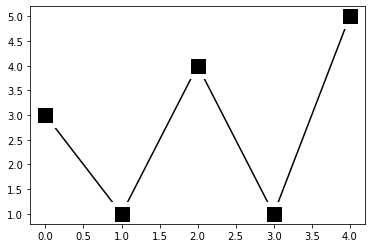

In [6]:
import matplotlib.pyplot as plt, mpld3
plt.plot([3,1,4,1,5], 'ks-', mec='w', mew=5, ms=20)
mpld3.show()
# mpld3.save_html(plt, "mpld-test.html")
# mpld3.save_json(plt, "mpld-test.json")


In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# method II: ggplot
from ggplot import *
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')

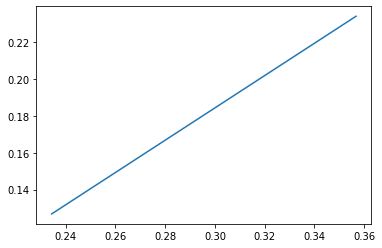

In [28]:
import matplotlib.pyplot as plt
import numpy as np

x = [0.356777, 0.23435]
y = [0.234125, 0.12677] 

# This is the ROC curve
plt.plot(x,y)
plt.show() 

# This is the AUC
auc = np.trapz(y,x)



<style>

</style>

<div id="THIS_IS_FIGID"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("THIS_IS_FIGID", {"width": 432.0, "height": 288.0, "axes": [{"bbox": [0.125, 0.125, 0.775, 0.755], "xlim": [0.9, 3.1], "ylim": [3.9, 6.1], "xdomain": [0.9, 3.1], "ydomain": [3.9, 6.1], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 11, "tickvalues": null, "tickformat": null, "scale": "linear", "fontsize": 10.0, "grid": {"gridOn": false}, "visible": true}, {"position": "left", "nticks": 11, "tickvalues": null, "tickformat": null, "scale": "line

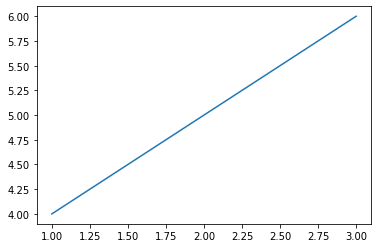

In [30]:
import mpld3
import matplotlib.pyplot as plt

f = plt.figure()
plt.plot([1,2,3], [4,5,6])

print(mpld3.fig_to_html(f, figid='THIS_IS_FIGID'))